In [1]:
import json, re

from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style="white", context="talk")

In [3]:
def get_noise_rate(result_path: Path) -> float:
    noise_paths = list(result_path.parent.glob("folder*.json"))
    if len(noise_paths) == 1:
        regex_result = re.findall(r"\d+\.\d+", noise_paths[0].name)
        noise_rate = float(regex_result[0])
        return noise_rate
    return 0.0

In [4]:
def parse_results(data_dir: Path) -> pd.DataFrame:
    result_paths = list(data_dir.glob("*-experiments/cl/**/results*.json"))
    results = []
    for p in result_paths:
        with open(p, "r") as fp:
            data = json.load(fp)

        for score in data["scores"]:
            results.append({
                "noise_rate": get_noise_rate(result_path=p),
                "algorithm_name": data["algorithm_name"],
                #"algorithm_n_folds": data["algorithm_params"]["n_folds"],
                #"algorithm_n_repetitions": data["algorithm_params"]["n_repetitions"],
                "start_time": datetime.strptime(data["start_time"], "%Y-%m-%dT%H:%M:%S%fZ"),
                "end_time": datetime.strptime(data["end_time"], "%Y-%m-%dT%H:%M:%S%fZ"),
                "type_1_error_rate": score["type_1_error_rate"],
                "type_2_error_rate": score["type_2_error_rate"],
                "noise_elimination_precision_score": score["noise_elimination_precision_score"],
                "n_mislabelled": len(data["known_mislabelled_indices"]),
                "n_detected": len(data["detected_mislabelled_indices"]),
                "mislabelled": data["known_mislabelled_indices"],
                "detected": data["detected_mislabelled_indices"],
            })
            
    df_data = pd.DataFrame(results)
    df_data["duration_min"] = np.round((df_data["end_time"] - df_data["start_time"]) / pd.Timedelta(minutes=1))
    df_data["detection_rate"] = df_data["n_detected"] / df_data["n_mislabelled"]
    return df_data

In [5]:
df_data = parse_results(Path("../data"))

In [6]:
df_score_data = df_data.sort_values("noise_rate").copy()
df_score_data = df_score_data[df_score_data.noise_rate > 0]

## Noise Detection Precision

Noise Detection Precision (NDP) is the percentage of detected instances that are known to be mislabelled.

$$
NDP =
\frac{
    \text{# of mislabelled samples which are correctly detected}
  }{
    \text{# of detected samples}
  }
$$

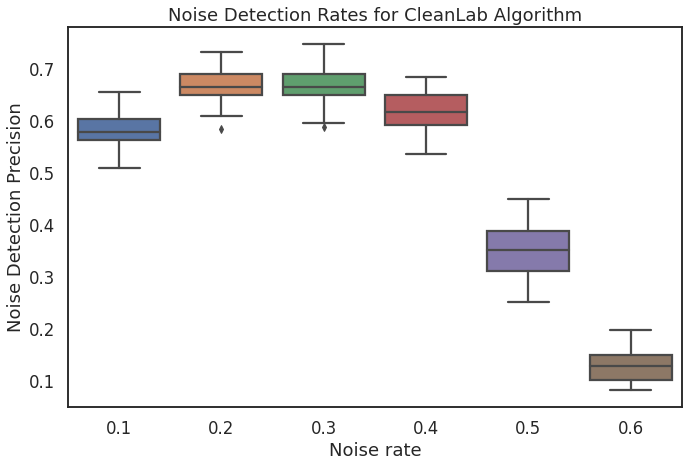

In [7]:
fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="noise_rate", y="noise_elimination_precision_score", data=df_score_data, ax=ax)
ax.set_xlabel("Noise rate")
ax.set_ylabel("Noise Detection Precision")
ax.set_title("Noise Detection Rates for CleanLab Algorithm");

- Detection precision is medium i.e., DPN is between $0.5$ and $0.75$ when noise rates are below $0.4$.
- Noise Detection Precision indicates the fraction of the detected samples that were actually mislabelled.

## Error Types

For noisy label detection algorithms, we want to determine whether the samples predicted as being noisy actually are mislabeled instances, and vice versa. We can distinguish between two types of errors. We say we say that an algorithms makes an:

- **Type 1 error** if the algorithm mistakenly identified a correctly labelled sample as mislabelled i.e., false postive / false alarm. Type 1 Error Rate, denoted $ER_1$, is computed as:

  $$
  ER_1=
  \frac{
    \text{# of correctly labelled samples wrongly detected as mislabelled}
  }{
    \text{# of correctly labelled samples}
  }
  $$
- **Type 2 error** if the algorithm did not identify an actually mislabelled instance in the data set i.e., false negative. Type 2 Error Rate, denoted $ER_2$, is computed as:

  $$
  ER_2=
  \frac{
    \text{# of undetected but known mislabelled samples}
  }{
    \text{# of known mislabelled samples}
  }
  $$


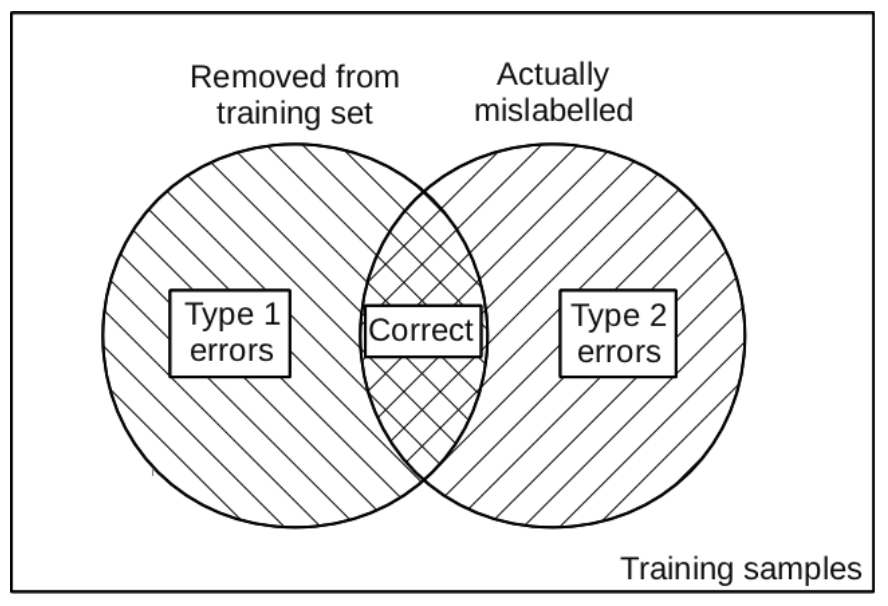


## Type 1 Error Rates

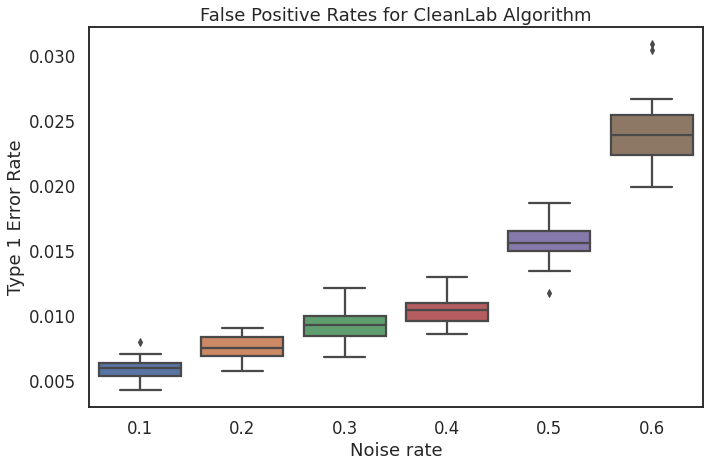

In [8]:
fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="noise_rate", y="type_1_error_rate", data=df_score_data, ax=ax)
ax.set_xlabel("Noise rate")
ax.set_ylabel("Type 1 Error Rate")
ax.set_title("False Positive Rates for CleanLab Algorithm");

- False positive rates are very small i.e., the number of clean samples which are mistakenly identified as noisy is small.
- This means that the algorithm does not detect many clean samples as mislabelled.

## Type 2 Error Rates

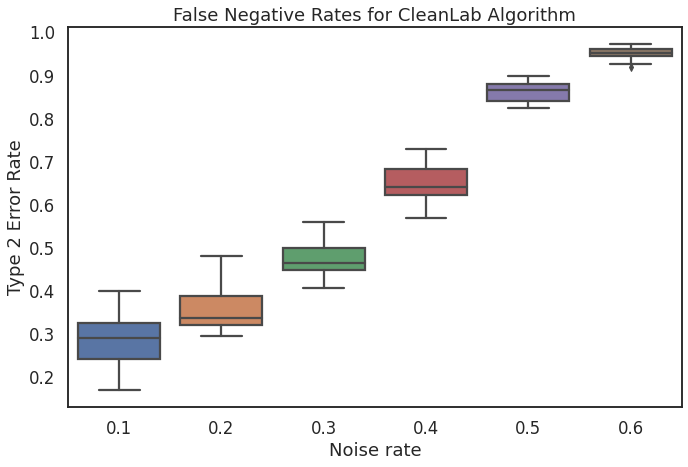

In [9]:
fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="noise_rate", y="type_2_error_rate", data=df_score_data, ax=ax)
ax.set_xlabel("Noise rate")
ax.set_ylabel("Type 2 Error Rate")
ax.set_title("False Negative Rates for CleanLab Algorithm");

- The false negative rate is relatively high.
- This means that many noisy samples are not caught by the algorithm. 

## Number of Mislabelled vs Detected

Let us examine whether the number of detected mislabellings increase with the noise rate.

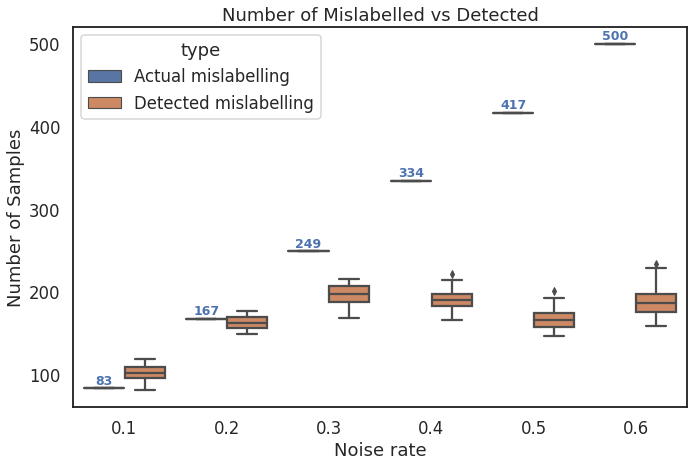

In [10]:
df_boxplot_data = pd.melt(
    frame=df_score_data[["noise_rate", "n_mislabelled", "n_detected"]],
    id_vars=["noise_rate"],
    var_name=["type"]
)
df_boxplot_data.replace({"type": "n_mislabelled"}, "Actual mislabelling", inplace=True)
df_boxplot_data.replace({"type": "n_detected"}, "Detected mislabelling", inplace=True)

fig, ax = plt.subplots(figsize=(11, 7))
box_plot = sns.boxplot(x="noise_rate", y="value", hue="type", data=df_boxplot_data, ax=ax)

vals = df_score_data.groupby("noise_rate")["n_mislabelled"].mean().to_numpy()

for xtick in box_plot.get_xticks():
    box_plot.text(
        x=xtick-0.2,
        y=vals[xtick]+5,
        s=vals[xtick], 
        horizontalalignment='center',size='x-small',color='b',weight='semibold')

ax.set_xlabel("Noise rate")
ax.set_ylabel("Number of Samples")
ax.set_title("Number of Mislabelled vs Detected");

- At lower noise rates $\leq 0.2$, the algorithm detects a larger number of samples than are actually mislabelled. 
- This indicates that even without injecting noise to the dataset  $\text{noise rate} = 0.0$, the algorithm is still identifying mislabelled samples.

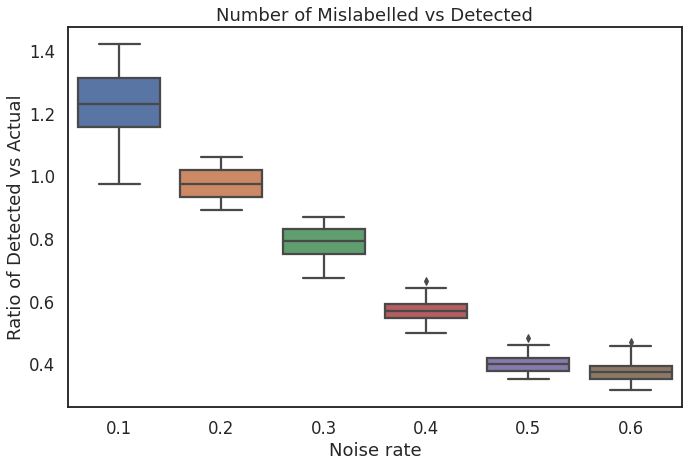

In [11]:
fig, ax = plt.subplots(figsize=(11, 7))
box_plot = sns.boxplot(x="noise_rate", y="detection_rate", data=df_score_data, ax=ax)

ax.set_xlabel("Noise rate")
ax.set_ylabel("Ratio of Detected vs Actual")
ax.set_title("Number of Mislabelled vs Detected");

## Detection without Noise

Interestingly, CleanLab is detecting noisy samples even before we introduce label noise into the data set.

In [12]:
df_zero_noise = df_data[df_data.noise_rate == 0]
all_items = []
for l in df_zero_noise["detected"]:
    all_items += l
detected_indices, counts = np.unique(all_items, return_counts=True) 

In [13]:
df_detected_counts = pd.DataFrame(detected_indices, columns=["product_index"])
df_detected_counts["detected_count"] = counts
df_detected_counts["n_experiments"] = df_zero_noise.shape[0]
df_detected_counts.sort_values("detected_count", ascending=False).head(20)

,product_index,detected_count,n_experiments
28,2617,12,12
13,1330,12,12
60,4156,12,12
47,3672,12,12
70,4994,12,12
82,5994,12,12
17,1825,12,12
15,1466,12,12
14,1388,12,12
55,3982,12,12


In [14]:
# df_products = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)
# df_filtered_products = df_products.loc[~df_products.index.isin(detected_indices)]
# df_filtered_products.to_csv('../data/ice-cat-office-products-filtered.csv.gz',)

## Summary

- CleanLab is a conservative detection algorithm, meaning it does not identify many samples as being mislabelled. 
  - This is evident from the fact that the number of detected samples does not increase significantly with increased noise rates.
  - The conservative nature partly explains the low the false positive (detecting clean samples as noisy samples) rates for lower noise rates.
- The false negative rates (not detecting noisy samples) is relatively high. This means that a large number of noisy samples are slipping through the detection filter.